# Problem Statement

New Foreign Expats might not know what is appropirate housing rental price in Singapore. We will built a regression model to predict the rental price given a set of housing features and recommend similar listings for the user. 

In this project, our scope is limit to the Condominium Renting Sector in Singapore.

# Evalution metrics

### RMSE

In this project, **RMSE** will be our **main metrics** to evaluate the for selecting the best model and evaluate the performance of the best model. For the following reason

1. **RMSE** is chosen as it punishes predicteed value that has greater difference than the actual value. This is important as we do not want our model to undervalue or overvalue a rental unit.

2. **RMSE** gaves us a better intuition of the error which is in the same unit of our response variable (price). In other words, the error tells us how much "wrong" we are in terms of dollar value from the actual value.

### $R^{2}$

Althought **RMSE** gave us the intuition of how "wrong" is the model prediction in terms of dollar value, performance of the model is not that obvious. Hence, we will be using $R^{2}$ to give an overall picture of how well is our model performing.

### Success Criteria

The ground truth of the impact of wrongly predicted value are unknown, and not part of the scope of this project.
However, We aim to perform better than guessing the average price of entire condominium rental price in our dataset. (Baseline).

# Imports and Settings

In [442]:
#!pip install missingno

In [443]:
import pandas as pd
import numpy as np
from IPython.display import display


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.base import BaseEstimator, TransformerMixin

import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

import missingno as msno
import re
from collections import defaultdict

import sys
import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base

from missingpy import MissForest
from sklearn.impute import SimpleImputer

import geocoder

In [444]:
#pandas setting
pd.set_option('max_columns', None)

#global rng
rng = np.random.RandomState(1)

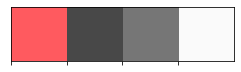

In [445]:
#colour template

pink = '#FF5A5F'
light_black = '#484848'
grey = '#767676'
background_color = "#fafafa"
face_color = '#fafafa'

sns.palplot([pink, light_black, grey, background_color])

# Data Description

|Feature|Type|Description|
|:---:|:---:|:---|
|**Amenities**|*Categorical*| Amenities of a Listing| 
|**bathroom**|*Discrete*|Number of bathroom of a listing|
|**bedroom**|*Discrete*|Number of bedroom of a listing|
|**detailed_address**|*Categorical*|address of a listing|
|**district**|*Categorical*|district number of a listing|
|**Floor Level**|*Nominal*|Low, Medium, High of a listing|
|**Furnishing**|*Nominal*|Furnished Level of a listing|
|**Link**|*Categorical*|website link to the listing|
|**mrt_distance**|*continuous*|walking time to the MRT|
|**mrt**|*continuous*|nearest MRT|
|**overview**|*Categorical*|Facing or View of the listing|
|**picture_url**|*Categorical*|picture of the listing|
|**picture_month**|*Continuous*|monthly price of the listing|
|**picture_sqrt**|*Continuous*|price_sqrt of the listing|
|**sqft**|*Continuous*|sqrt of the listing|
|**year_built**|*Discrete*|year built of the listing|

In [446]:
df = pd.read_csv("Data\scraped_df.csv")

In [447]:
df.shape

(7454, 24)

In [448]:
df = df.drop_duplicates()
df.shape

(7449, 24)

In [449]:
df = df.rename(columns={'price/sqft': 'price_sqft', 'name': 'building_name'})
df.head(2)

,amenities,built_year,detailed_address,developer,district,facing,floor_level,furnishing,link,mrt_distance,mrt_name,building_name,neighbourhood,overlooking_view,picture_url,price_sqft,price_month,property_type,sqft,tenure,total_units,unit_types,bedrooms,bathrooms
0,"['Penthouse', 'Stove', 'Library', 'Walk in clo...",2016.0,3 Wallich Street,Guocoland Limited,Chinatown / Tanjong Pagar (D2),North South,High (64 total),Fully,https://www.99.co/singapore/rent/property/wall...,5 min (75 m) from,Tanjong Pagar MRT,Wallich Residence,None,Pool view,https://pic.99.co/v3/GkrtLkrfYpXDLrZQVeHtp2?wi...,$10.53 psf,"$6,800/mo",Condo Whole Unit,646,99 Years,181.0,"Studio, 1, 2, 3, 4, 5 BR",1,1.0
1,"['Bathtub', 'Renovated', 'Aircon', 'Maid room'...",1970.0,1 Claymore Drive,NaN,Orchard / River Valley (D9),NaN,High,Partial,https://www.99.co/singapore/rent/property/orch...,10 min (478 m) from,Orchard MRT,Orchard Towers,Orchard,NaN,https://pic.99.co/v3/C8G5McHGEiEzGnQ6Y53vm5?wi...,$2.54 psf,"$5,000/mo",Condo Whole Unit,"1,970",Freehold,58.0,"1, 3, 4, 5, 7 BR",4,4.0


In [450]:
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7449 entries, 0 to 7453
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   amenities         7449 non-null   object 
 1   built_year        7328 non-null   float64
 2   detailed_address  7409 non-null   object 
 3   developer         6455 non-null   object 
 4   district          7449 non-null   object 
 5   facing            555 non-null    object 
 6   floor_level       1318 non-null   object 
 7   furnishing        2306 non-null   object 
 8   link              7449 non-null   object 
 9   mrt_distance      6464 non-null   object 
 10  mrt_name          6464 non-null   object 
 11  building_name     7449 non-null   object 
 12  neighbourhood     7449 non-null   object 
 13  overlooking_view  1244 non-null   object 
 14  picture_url       7449 non-null   object 
 15  price_sqft        7400 non-null   object 
 16  price_month       7449 non-null   object 


#  Irrelavent Feature & Data Type &  Missing Values

## Irrelavent Feature

In [451]:
#irrelevant Feature
drop = [
'sqft',#sqft feature can be derived from price/sqrt. We will delete this feature since it has missing values and use price/sqrt to derive
'developer',# we assumed developer has no impact on the price of a listing, should our model show bias, we will revist this feature
'total_units',# we assumed total_units has no impact on the price of a listing,, should our model show bias, we will revist this feature
'property_type', #condominium only
'unit_types',# we assumed unit_types has no impact on the price of a listing,, should our model show bias, we will revist this feature
]
df = df.drop(labels=drop, axis=1 )

## Dropping Variable With High Missing Value

<AxesSubplot:>

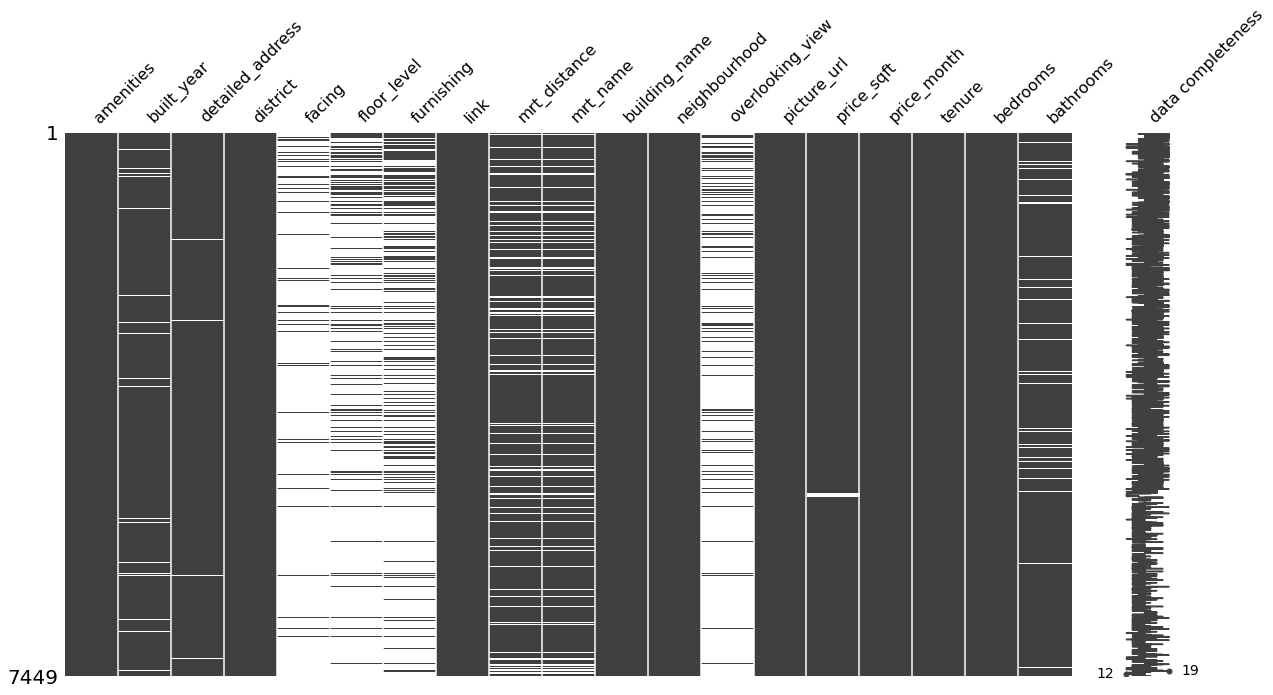

In [452]:
msno.matrix(df, labels=True, figsize=(20, 10))

<AxesSubplot:>

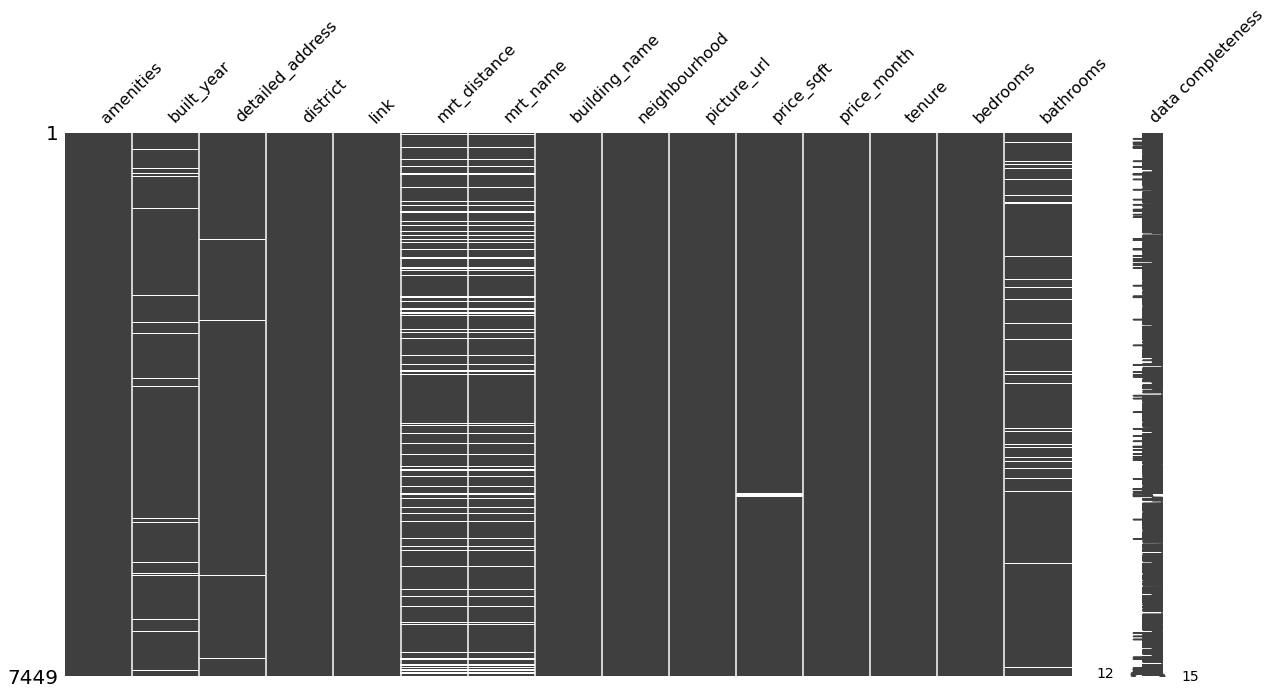

In [453]:
#dropping off column with more than 50% missing value (Reference multivariate-data-analysis-8th-edition rule of thumb)
thresh = len(df)*0.5
df = df.dropna(axis=1, thresh=thresh)
msno.matrix(df, labels=True, figsize=(20, 10))

## Changing Data Type

### price_month

In [454]:
#changing price_month to numeric
df['price_month'] = pd.to_numeric(
    #placing the '/mo', '$', ','
    df.price_month.str.replace('/mo','').str.replace('$','').str.replace(',','')
)

<ipython-input-454-923808e2f9df>:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df.price_month.str.replace('/mo','').str.replace('$','').str.replace(',','')


### price_month

In [455]:
#price_sqrt
df['price_sqft'] = pd.to_numeric(
    df['price_sqft'].str.replace('psf', '').str.replace('$','').str.replace(',', "")
)

<ipython-input-455-a6eb10e66794>:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df['price_sqft'].str.replace('psf', '').str.replace('$','').str.replace(',', "")


### mrt_distance

In [456]:
# mrt_distance
#There is two types of information. One is walking time the other one is distance. 
#We will create two feature from this raw input.

df['walking_time'] = df.mrt_distance.str.extract(r'([\d]+) min')
df['distance'] = df.mrt_distance.str.extract(r'([\d]+) m\)')

In [457]:
#converting object to numeric
df['walking_time'] =  pd.to_numeric(df.walking_time, errors='coerce')
df['distance'] = pd.to_numeric(df.distance, errors='coerce')

# we will drop mrt_walking distance since we have convert it into walking_time & distance column
df.drop('mrt_distance', axis = 1, inplace=True)

#### bedrooms

bedrooms contains object studio, we will create a new feature to indicate if the listing is a studio,  and replace bedrooms with 1

In [458]:
#new feature to indicate if studio
df['studio'] = np.where(df.bedrooms == 'studio', 1, 0)

#replace bedrooms for studio = 1
df['bedrooms'] = np.where(df.bedrooms == 'studio', 1, df.bedrooms)
df['bedrooms'] = pd.to_numeric(df.bedrooms)

### amenities

In [459]:
#cleaning amenities
#before
df['amenities'] = df.amenities.str.replace("'", "").str.replace('[', '').str.replace(']', '').str.replace(', ', ',')
df['amenities'][0]

<ipython-input-459-10fe62a2f114>:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df['amenities'] = df.amenities.str.replace("'", "").str.replace('[', '').str.replace(']', '').str.replace(', ', ',')


'Penthouse,Stove,Library,Walk in closet,Jacuzzi,Oven,Renovated,Closet,,,,,,,,,,,,,,,,,'

In [460]:
#after
def cleaning(items):
    return [item for item in items.split(',') if item != '']
df['amenities'] = df['amenities'].apply(cleaning)
df['amenities'][0]

['Penthouse',
 'Stove',
 'Library',
 'Walk in closet',
 'Jacuzzi',
 'Oven',
 'Renovated',
 'Closet']

#### neighbhourhood

In [461]:
#replacing None with np.nan
df['neighbourhood'] = np.where(df.neighbourhood == 'None', np.nan, df.neighbourhood)

#### District

In [462]:
#changing data type of district
df['district_number'] = df.district.str.extract(r'D([\d]+)')

#converting object to numeric
df['district_number'] = pd.to_numeric(df.district_number, errors='coerce')

#we will drop district after covert it into numerical
df = df.drop('district', axis=1)

#### Tenure

In [463]:
#1 = Freehold, 0 = otherwise
df['tenure'] = np.where(df.tenure == 'Freehold', 1, 0)

In [464]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7449 entries, 0 to 7453
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   amenities         7449 non-null   object 
 1   built_year        7328 non-null   float64
 2   detailed_address  7409 non-null   object 
 3   link              7449 non-null   object 
 4   mrt_name          6464 non-null   object 
 5   building_name     7449 non-null   object 
 6   neighbourhood     5605 non-null   object 
 7   picture_url       7449 non-null   object 
 8   price_sqft        7400 non-null   float64
 9   price_month       7449 non-null   int64  
 10  tenure            7449 non-null   int32  
 11  bedrooms          7442 non-null   float64
 12  bathrooms         7108 non-null   float64
 13  walking_time      6464 non-null   float64
 14  distance          6464 non-null   float64
 15  studio            7449 non-null   int32  
 16  district_number   7449 non-null   int64  


## Imputing Row wise Missing Values

### Row-wise not affected by datasnooping

#### Imputing mrt_name

i have searched a few listing on why they have not listed the mrt name, and it is due to it being far away from mrt.
i will impute it with No Mrt for mrt, and the distance/time will set to maximum of the value of the entire df

In [465]:
df.mrt_name.fillna('No_MRT', inplace=True)

In [466]:
df.walking_time.fillna(df.walking_time.max(), inplace=True)
df.distance.fillna(df.distance.max(), inplace=True)

#### Imputing Detailed Address

In [467]:
df.detailed_address.fillna('No_Address', inplace=True)

#### Imputing Neighbhourhood

In [468]:
df.neighbourhood.isna().sum()/len(df)

0.24755000671231037

In [469]:
# district number of missing value
missing_neighbhour = df.loc[df.neighbourhood.isna(), 'district_number'].value_counts()
missing_neighbhour

1    640
9    407
2    384
7    217
3    120
4     39
6     23
8     14
Name: district_number, dtype: int64

In [470]:
#entire district value count
df.district_number.value_counts().loc[missing_neighbhour.index]

1     640
9    1739
2     431
7     242
3     326
4     158
6      23
8     144
Name: district_number, dtype: int64

We can see that the **Neighbhour** missing value is not MCAR/MAR. In Fact the entire district 1 neighbhourhood is missing. Hence it could be that the neighbhour is not defined for a particular district.Instead of using neighbourhood. We will use district number instead.

In [471]:
df = df.drop('neighbourhood', axis=1)

### Row-wise affected by datasnooping

In [472]:
# we want to preserve the ratio district hence stratifting df_strict
df_train, df_test = train_test_split(df, train_size=0.8,stratify=df[['district_number']],random_state=rng)

In [473]:
#General Function of Imputing Missing Value
#only works for imputing numerical value
def impute_missingvalue(df_train, df_test, used_column, missing_column):
    
    
    #create original dataframe to be combine with the column with missing value imputed
    df_train_original = df_train.copy()
    df_test_original = df_test.copy()
    
    #column used to impute value
    df_train = df_train.loc[:, used_column]
    df_test = df_test.loc[:, used_column]
    
    #select object column for columnstransformer for ohe
    object_column = df_train.select_dtypes('object').columns.tolist() 
    
    #create column transformer to transform object column, remainder will be passthrough
    ohe = OneHotEncoder(handle_unknown='ignore')
    ct = make_column_transformer(
        (ohe, object_column),
        remainder = 'passthrough'
    )     
    
#     #miss forest
    missforest = MissForest(random_state=rng)
    
#     #pipeline for transformation
    df_train = ct.fit_transform(df_train)
    train_columns = ct.get_feature_names()
    df_train = missforest.fit_transform(df_train.toarray())
    df_train = pd.DataFrame(df_train, columns = train_columns)
    
        
    df_test = ct.transform(df_test)
    df_test = missforest.transform(df_test.toarray())
    df_test = pd.DataFrame(df_test, columns = train_columns)
    
    for missing_feature in missing_column:
        df_train_original[missing_feature] = df_train[missing_feature].values
        df_test_original[missing_feature] = df_test[missing_feature].values


 
    return df_train_original, df_test_original
   

We will plot the before & after value distribution for columns with missing value to check if there is a change in distribution

In [474]:
def plot_missing_distribution(df_before,df_after, column, title):
    
    fig , ax = plt.subplots(nrows = 2, ncols = len(column), figsize=(16,6))

    for idx, col in enumerate(missing_value_columns):
        sns.histplot(df_before[col], bins='auto', ax=ax[0][idx],color='b')
        ax[0][idx].set_ylabel('')
        ax[0][idx].set_xlabel('')

        
    for idx, col in enumerate(missing_value_columns):
        sns.histplot(df_after[col], bins='auto', ax=ax[1][idx], color='r')
        ax[1][idx].set_ylabel('')
        

    fig.suptitle(title, fontsize=20);

    

In [475]:
#impute missing values
df_train_imp, df_test_imp = impute_missingvalue(df_train, 
                    df_test,
                    #features used to predict missing values                            
                    ['built_year', 'price_sqft', 'detailed_address','bedrooms', 'bathrooms', 'price_month', 'district_number'],
                    #features with missing values                             
                    ['built_year', 'price_sqft', 'bedrooms', 'bathrooms'] )

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


Missforest returns the results as a continuous value.
we will need to round values for built_year, bedrooms, bathrooms as these are discrete values

In [476]:
missing_value_columns = ['built_year', 'bedrooms', 'bathrooms']

for col in missing_value_columns:
    df_train_imp[col] = np.round(df_train_imp[col])
    df_test_imp[col] = np.round(df_test_imp[col])

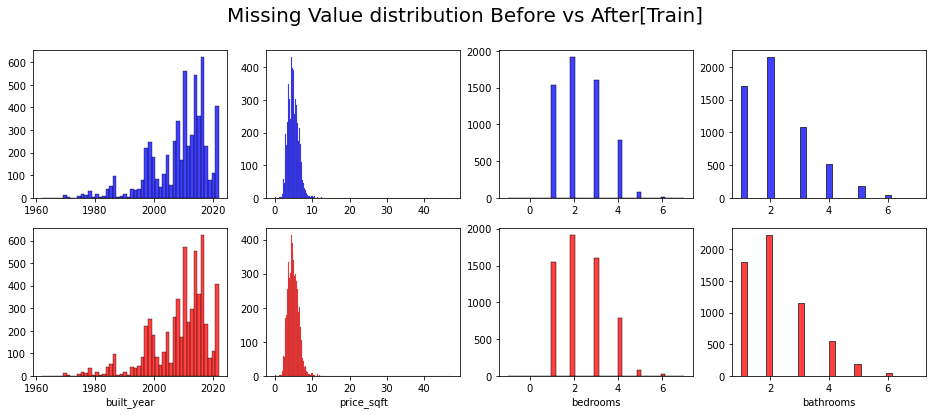

In [477]:
missing_value_columns = ['built_year', 'price_sqft', 'bedrooms', 'bathrooms']

plot_missing_distribution(df_train, df_train_imp, missing_value_columns, 'Missing Value distribution Before vs After[Train]')

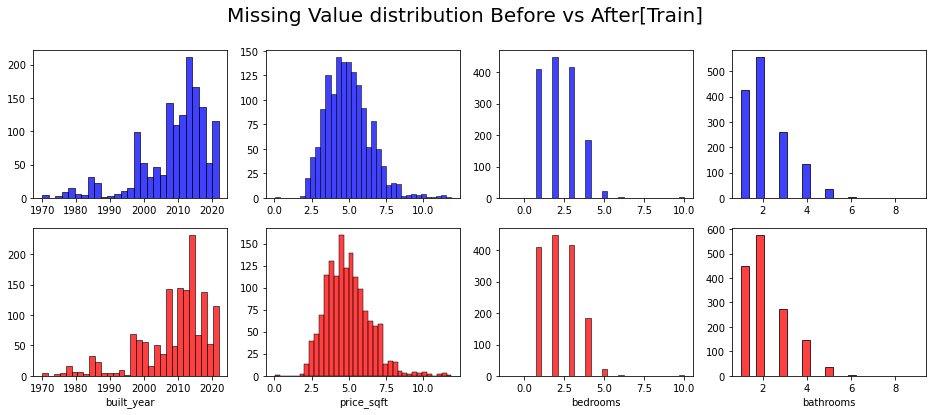

In [478]:
plot_missing_distribution(df_test, df_test_imp, missing_value_columns, 'Missing Value distribution Before vs After[Train]')

In [479]:
#there is little changes in the distribution,

<AxesSubplot:>

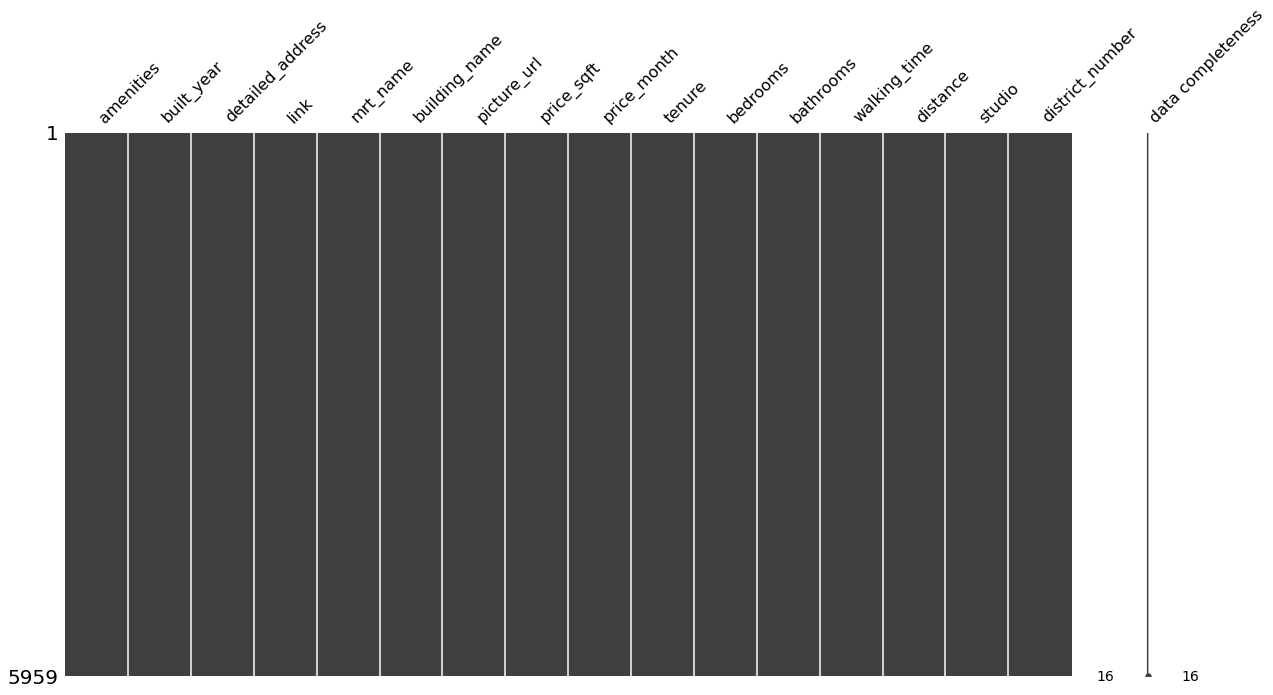

In [480]:
msno.matrix(df_train_imp, labels=True, figsize=(20, 10))

<AxesSubplot:>

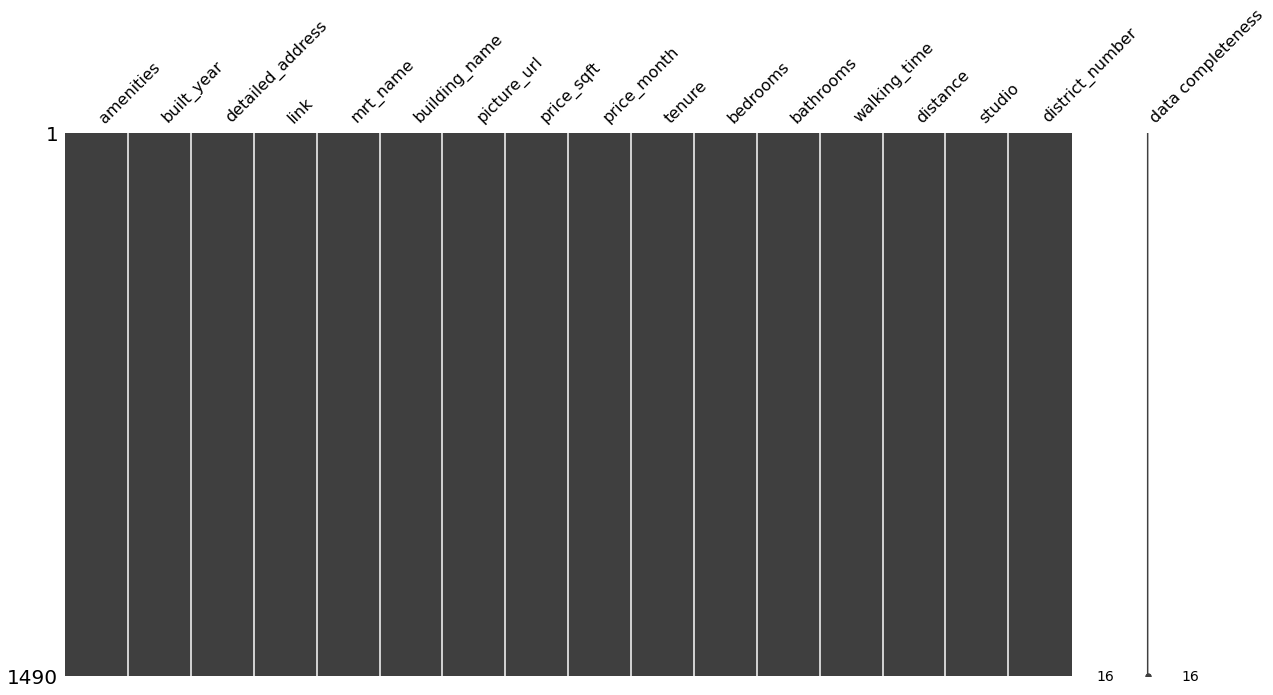

In [481]:
msno.matrix(df_test_imp, labels=True, figsize=(20, 10))

In [482]:
#override
df_train = df_train_imp
df_test = df_test_imp

# Outlier

Outliers should be detected and removed only from the training set, and NOT from the test set. That way we can evaluate that our model is doing well despite removing the outlier.

In [483]:
def diagnostic_plots(df, variable, title):
    """
    function takes a dataframe and
    the variable of interest as arugments
    for checking outliers
    """
    
    fig , ax = plt.subplots(nrows = 1, ncols = 3, figsize=(15,4))
    
    #histogram
    sns.histplot(df[variable], bins='auto', ax=ax[0])
    ax[0].set_title('Distribution')
    
    #Q-Q plot
    stats.probplot(df[variable], dist='norm', plot=ax[1])

    
    #boxplot
    sns.boxplot(y=df[variable], ax=ax[2])
    plt.title("Boxplot")
    
    fig.suptitle(title, fontsize=15)
    plt.show()
    

## Bathrooms

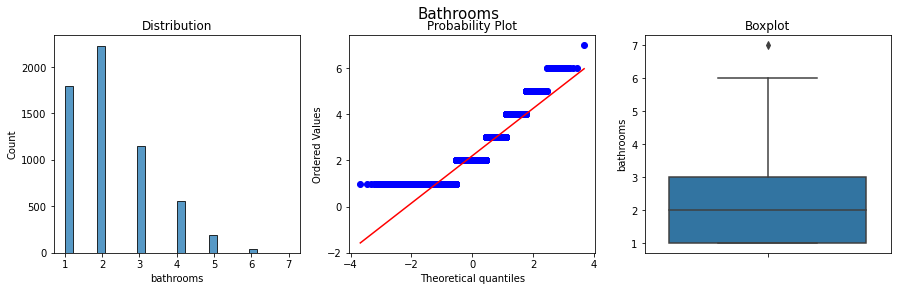

In [484]:
diagnostic_plots(df_train, 'bathrooms', title='Bathrooms')

In [485]:
#finding the outlier with 7 to 9 bathroom
df_train.loc[df_train.bathrooms.isin([7, 9]), :]

,amenities,built_year,detailed_address,link,mrt_name,building_name,picture_url,price_sqft,price_month,tenure,bedrooms,bathrooms,walking_time,distance,studio,district_number
4522,"[Clubhouse, Gym, Sauna, Lounge, Swimming pool,...",2015.0,18 Nassim Hill,https://www.99.co/singapore/rent/property/the-...,No_MRT,The Nassim,https://www.99.co/static/v3/icons/clubhouse@3x...,9.63,68000,1,5.0,7.0,35.0,5169.0,0,10


Analysis above shows the the outlier is not an anomoly/entry error. It is indeed a high value valid listing. 
We will keep the "outlier"

## Bedrooms

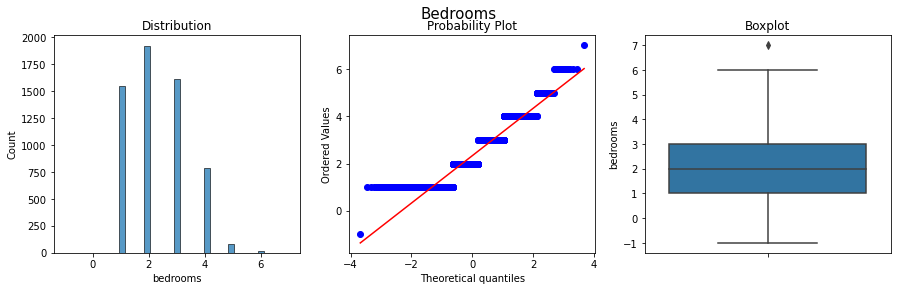

In [486]:
diagnostic_plots(df_train, 'bedrooms', title='Bedrooms')

In [487]:
#finding the outlier with more than 6 bedrooms
df_train.loc[df_train.bedrooms > 6, :]

,amenities,built_year,detailed_address,link,mrt_name,building_name,picture_url,price_sqft,price_month,tenure,bedrooms,bathrooms,walking_time,distance,studio,district_number
6337,[],1970.0,400 Orchard Road,https://www.99.co/singapore/rent/property/orch...,Orchard MRT,Orchard Towers,https://financialtribune.com/sites/default/fil...,3.8,7980,1,7.0,4.0,10.0,478.0,0,9


We have analysis each of the above listing and found that #index 6337 is actually listing for office. We will proceed to delete it.
#index 5659 & 2638 is a valid listing. We will keep it

In [488]:
df_train = df_train.drop(index=6337)

## Year Built

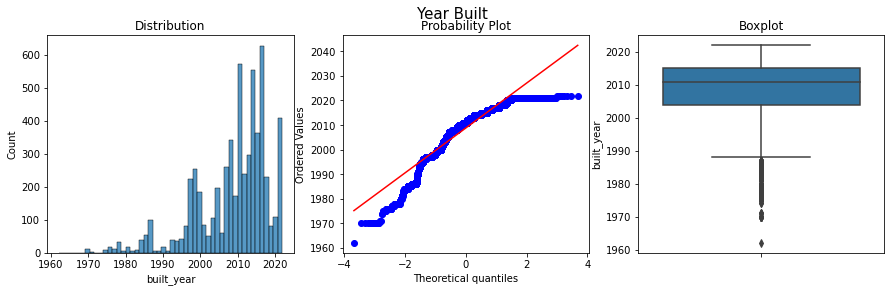

In [489]:
diagnostic_plots(df_train, 'built_year', title='Year Built')

we can see that most of the condominium listing in this dataframe are built around 2000 - 2015. The outlier is an acceptable values

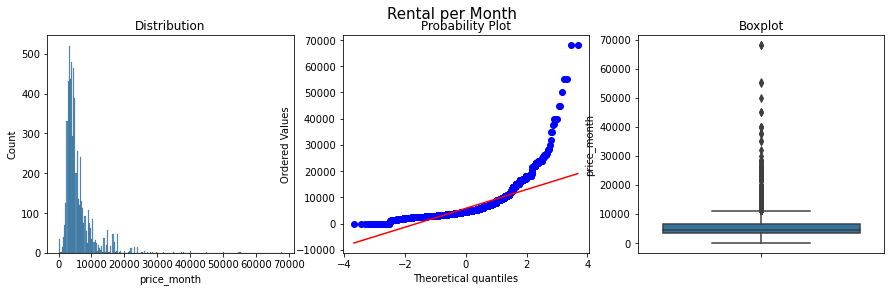

In [490]:
diagnostic_plots(df_train, 'price_month', title='Rental per Month')

## Price_month

In [491]:
def find_skewed_boundary(df, variable, distance):
    
    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)
    
    lower_boundary = df[variable].quantile(0.25) - IQR * distance
    upper_boundary = df[variable].quantile(0.75) + IQR * distance
    print(f'{lower_boundary=}, {upper_boundary=}')
    return lower_boundary, upper_boundary

In [492]:
_, upper = find_skewed_boundary(df_train, 'price_month', 3)

lower_boundary=-5900.0, upper_boundary=15800.0


In [493]:
df_train.loc[df_train.price_month > upper, ].shape[0]

238

There are 216 extreme outliers. I have investigated the above listings and found that the price_month is valid and not a typo error. We should not delete these listings just because their values are extreme as they are part of the singapore condominium population.

In [494]:
# df_train.to_csv('Data/df_train.csv', index=False)
# df_test.to_csv('Data/df_test.csv', index=False)